## Noisy RGB pixels, ormalize + Conv + UNet + Residual + Conv + Residual + Un-normalize, 1/8 U-Net bottleneck, L1/L2 + Perceptual + Adversarial Loss + Color Correction Loss

Same as version 1, normalize channels by mean and std before denoising. Results don't improve.

In [1]:
import torch
import torch.nn.functional as F
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [2]:
from plot_data import load_data

import oidn.wrapper
import importlib
importlib.reload(oidn.wrapper)
oidn_model = oidn.wrapper.load_model()



def plot_frame(frame):
    if frame.shape[0] == 1:
        frame = np.repeat(frame, 3, 0)
    frame = np.clip(frame, 0.0, 1.0)
    frame = np.einsum('kij->ijk', np.flip(frame, axis=1))
    plt.figure()
    plt.imshow(frame)
    plt.show()


def load_data_file(filename, verbose=False):
    bufferview = load_data(filename)
    images = {}
    img_sum = 0.0 * bufferview[0]['buffer']
    w = 0.0
    for image in bufferview:
        images[image['name']] = image['buffer']
        if not image['name'] >= 1:
            continue
        w += image['name']
        img_sum += image['name'] * image['buffer']

    # noise images less than 1spp
    sub = []
    for e in range(1, 4+1, 1):
        spp = 2**(-e)
        if spp not in images:
            break
        img = np.nan_to_num(images[spp], nan=0.0, posinf=0.0, neginf=0.0)
        sub.append(img)

    # power of 2 images greater than 1spp
    data = []
    for e in range(0, len(images)-len(sub)):
        spp = 2**e
        if spp not in images:
            break
        data.append(images[spp])
    data = np.array(data)
    data = np.nan_to_num(data, nan=0.0, posinf=0.0, neginf=0.0)

    # reference image, denoise with oidn
    ref = img_sum / w
    with torch.no_grad():
        x = ref.reshape((1, *ref.shape))
        x = np.fmax(x, 0.0) ** (1.0/2.2)
        x = torch.tensor(x).to(device)
        y = oidn_model(x)
        ref = np.fmax(y[0].cpu().numpy(), 0.0) ** 2.2

    if verbose:
        print(len(sub), data.shape, data.dtype, ref.shape, ref.dtype)
        plot_frame(ref**(1.0/2.2))
    return {
        'sub': sub,
        'data': data,
        'ref': ref
    }

# _ = load_data_file("data/implicit3-rt_0c2c00f9b182_1024.bin", verbose=True)

torch.Size([8, 3, 256, 256])


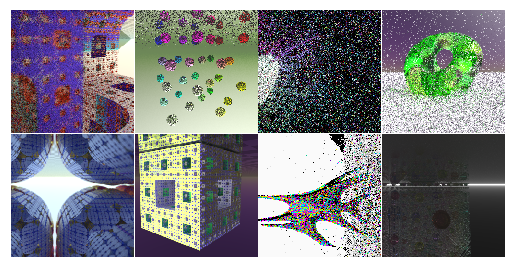

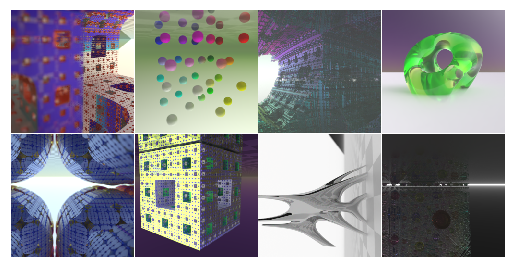

In [3]:
import random

class RawDataset(torch.utils.data.Dataset):
    def __init__(self, n):
        import os
        self.data = []
        for root, dirs, files in os.walk('data/'):
            for filename in files:
                filename = os.path.join(root, filename)
                try:
                    self.data.append(load_data_file(filename))
                except:
                    pass
        self.n = n
    
    def __len__(self):
        return 65536

    def __getitem__(self, i):

        # random data
        img = self.data[random.randint(0,len(self.data)-1)]
        clean = img['ref']

        # random chance to get <1spp image
        if random.random() < 0.0:
            noisy = random.choice(img['sub'])

        # clean image - random spp, sample from spp
        else:
            n = img['data'].shape[0]
            spp = max(round(0.6 * np.random.random()**4 * 2**n), 1)
            total = 0.0
            weight = 0.0
            for _ in range(n):
                if (spp >> _) & 1 == 0:
                    continue
                frame = img['data'][_]
                dw = ((frame > 0.0) & (frame < 1e6)).astype(np.float32) * 2**_
                total += frame * dw
                weight += dw
            noisy = total / np.fmax(weight, 1.0)

        # random flip/rotate/transpose
        if random.random() < 0.5:
            noisy = np.flip(noisy, 0)
            clean  = np.flip(clean,  0)
        if random.random() < 0.5:
            noisy = np.flip(noisy, 1)
            clean = np.flip(clean, 1)
        if random.random() < 0.5:
            noisy = np.swapaxes(noisy,  1, 2)
            clean = np.swapaxes(clean, 1, 2)

        # random swap color channels
        cidx = [0, 1, 2]
        random.shuffle(cidx)
        noisy = noisy[cidx]
        clean = clean[cidx]

        return [
            np.fmax(noisy, 0.0) ** (1.0/2.2),
            np.fmax(clean, 0.0) ** (1.0/2.2)
        ]


def plot_imgs(x):
    plt.figure()
    x = torch.clip(x, 0.0, 1.0)
    x = torch.flip(x, [2])
    plt.imshow(np.transpose(vutils.make_grid(x[:8].cpu(),
        nrow=4, padding=2, pad_value=1, normalize=True), (1, 2, 0)),
                interpolation='nearest')
    plt.axis("off")
    plt.show()

for x, y in torch.utils.data.DataLoader(
    RawDataset(128),
    batch_size=8,
    shuffle=True
):
    break

print(x.shape)
plot_imgs(x)
plot_imgs(y)

In [4]:
def conv3(nin, nout):
    return torch.nn.Conv2d(nin, nout, 3, padding=1, bias=True)

def conv1(nin, nout):
    return torch.nn.Conv2d(nin, nout, 1, padding=0, bias=True)

def dconv4(nin, nout):
    return torch.nn.ConvTranspose2d(nin, nout, 4, 2, 1, bias=True)

def relu(x, inplace=True):
    return F.relu(x, inplace)

def pool(x):
    return F.max_pool2d(x, 2)

def concat(a, b):
    return torch.concat((a, b), axis=1)

class Model(torch.nn.Module):
    def __init__(self):
        super().__init__()
        n0 = 12
        n1 = 16
        n2 = 24
        n3 = 32
        self.convi = conv3(3, n0)
        self.econv0a = conv3(n0, n0) # 1
        self.econv0b = conv3(n0, n0) # 1
        self.econv1a = conv3(n0, n1) # 1/2
        self.econv1b = conv3(n1, n1) # 1/2
        self.econv2a = conv3(n1, n2) # 1/4
        self.econv2b = conv3(n2, n2) # 1/4
        self.econv3a = conv3(n2, n3) # 1/8
        self.econv3b = conv3(n3, n3) # 1/8
        self.dconv2a = dconv4(n3, n2) # 1/8->1/4
        self.dconv2b = conv1(n2+n2, n2) # 1/4
        self.dconv1a = dconv4(n2, n1) # 1/4->1/2
        self.dconv1b = conv1(n1+n1, n1) # 1/2
        self.dconv0a = dconv4(n1, n0) # 1/2->1
        self.dconv0b = conv1(n0+n0, n0) # 1
        self.convo = conv3(n0, 3)

    def forward(self, input):
        mean = torch.mean(input, (2, 3), True)
        std = torch.std(input, (2, 3)).unsqueeze(2).unsqueeze(3)
        xi = (input-mean)/std
        ci = self.convi(xi)
        e0 = self.econv0b(relu(self.econv0a(relu(ci, False)))) # 1
        e1 = self.econv1b(relu(self.econv1a(pool(e0)))) # 1/2
        e2 = self.econv2b(relu(self.econv2a(pool(e1)))) # 1/4
        e3 = self.econv3b(relu(self.econv3a(pool(e2)))) # 1/8
        d2 = relu(self.dconv2a(relu(e3))) # 1/4
        d2 = relu(self.dconv2b(concat(d2, e2))) # 1/4
        d1 = relu(self.dconv1a(d2)) # 1/2
        d1 = relu(self.dconv1b(concat(d1, e1))) # 1/2
        d0 = relu(self.dconv0a(d1)) # 1
        do = relu(self.dconv0b(concat(d0, e0))) # 1
        xo = self.convo(ci+do)+xi
        return xo*std+mean


model = Model().to(device)
print(model)

x = torch.randn((8, 3, 256, 256), device=device)
print(model(x).shape)

Model(
  (convi): Conv2d(3, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (econv0a): Conv2d(12, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (econv0b): Conv2d(12, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (econv1a): Conv2d(12, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (econv1b): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (econv2a): Conv2d(16, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (econv2b): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (econv3a): Conv2d(24, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (econv3b): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (dconv2a): ConvTranspose2d(32, 24, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (dconv2b): Conv2d(48, 24, kernel_size=(1, 1), stride=(1, 1))
  (dconv1a): ConvTranspose2d(24, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (dconv1b): Conv2d(32, 16, kernel_size=(1, 1)

In [5]:
"""Image Denoising Using A Generative Adversarial Network,
    Code modified from implementation by Jeffrey Ming Han Li"""

class Discriminator(torch.nn.Module):
    def __init__(self,K2):
        super(Discriminator, self).__init__()

        # Basic convolutional block
        def conv_block(in_channels, out_channels, kernel_size, stride):
            return torch.nn.Sequential(
                torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding=1),
                torch.nn.BatchNorm2d(out_channels),
                torch.nn.LeakyReLU(0.01, inplace=True)
            )
        def last_block(in_channels, out_channels, kernel_size, stride):
            return torch.nn.Sequential(
                torch.nn.Conv2d(in_channels,out_channels,kernel_size,stride,1),
                torch.nn.BatchNorm2d(out_channels),
                torch.nn.Sigmoid()
            )

        self.model = torch.nn.Sequential(
            conv_block(3,K2, kernel_size=4, stride=2),
            conv_block(K2,3*K2//2, kernel_size=4, stride=2),
            conv_block(3*K2//2,K2*2, kernel_size=4, stride=2),
            conv_block(K2*2,K2*3, kernel_size=4, stride=2),
            conv_block(K2*3,K2*4, kernel_size=4, stride=2),
            conv_block(K2*4,K2*4, kernel_size=3, stride=1),
            last_block(K2*4,1, kernel_size=3, stride=1)
        )

    def forward(self, x):
        y = self.model(x)
        # print(y.shape)
        return torch.clip(torch.mean(y, axis=(2, 3)), 0.0, 1.0)


class CombinedLoss(torch.nn.Module):
    def __init__(self, lambda_a, lambda_p, lambda_f, lambda_c, device='cpu'):
        super(CombinedLoss, self).__init__()
        self.lambda_a = lambda_a  # adversarial
        self.lambda_p = lambda_p  # pixel loss
        self.lambda_f = lambda_f  # feature loss (perceptual)
        # self.lambda_t = lambda_t  # texture matching loss
        self.lambda_t = 0.0
        self.lambda_c = lambda_c  # correct color shift caused by GAN

        # loss function for GAN
        self.bce = torch.nn.BCEWithLogitsLoss()

        # VGG16 model for feature and texture loss
        import torchvision.models
        vgg16 = torchvision.models.vgg16(weights='VGG16_Weights.DEFAULT')
        vgg_mean = torch.tensor([0.485, 0.456, 0.406]).view(1, 3, 1, 1).to(device)
        vgg_std = torch.tensor([0.229, 0.224, 0.225]).view(1, 3, 1, 1).to(device)

        # vgg first layer
        self.feature_extractor = vgg16.features[:4].to(device)
        for param in self.feature_extractor.parameters():
            param.requires_grad = False
        self.feature_extractor_1 = lambda x: self.feature_extractor((x-vgg_mean)/vgg_std)
        # print(self.feature_extractor)

        # vgg second layer, after first layer
        self.feature_extractor_2 = vgg16.features[4:9].to(device)
        for param in self.feature_extractor_2.parameters():
            param.requires_grad = False
        # print(self.feature_extractor_2)
    
    @staticmethod
    def gram(x, s):
        if x.shape[2] % s != 0 or x.shape[3] % s != 0:
            raise ValueError("Image dimension not multiple of texture patch size")
        x = x.view(x.shape[0], x.shape[1], x.shape[2]//s, s, x.shape[3]//s, s)
        x = x.permute(0, 1, 2, 4, 3, 5).contiguous()
        x = x.view(x.shape[0], x.shape[1], -1, s*s)
        g = torch.matmul(x, x.transpose(3, 2))
        return g / (s*s)
    
    @staticmethod
    def mask_non_finite(x, v):
        nan_mask = torch.isnan(x)
        inf_mask = torch.isinf(x)
        x[nan_mask] = v
        x[inf_mask] = v
        return x
    
    def forward(self, generated, target, discriminator_output, is_discriminator=False):
        # normalization parameters
        normalize_l2 = 1.0 / 0.05  # change this to estimated L1 loss
        normalize_vgg = 1.0 / 0.225
        normalize_l2_vgg = normalize_l2 / normalize_vgg
        normalize_l2_vgg_gram = normalize_l2_vgg ** 2

        # adversarial Loss
        if is_discriminator:
            return self.bce(discriminator_output, target)
        # loss_a = -torch.mean(discriminator_output)
        loss_a = self.bce(1.0-discriminator_output, torch.ones_like(discriminator_output))

        # pixel loss (L1+L2)
        loss_p2 = torch.mean((generated-target)**2) * normalize_l2
        loss_p1 = torch.mean(torch.abs(generated-target))
        loss_p = 0.5*(loss_p1+loss_p2)

        # feature loss (L1+L2)
        gen_features = self.feature_extractor_1(generated)
        tgt_features = self.feature_extractor_1(target)
        loss_f1l2 = torch.mean((gen_features-tgt_features)**2) * normalize_l2_vgg
        loss_f1l1 = torch.mean(torch.abs(gen_features-tgt_features))
        gen_features_2 = self.feature_extractor_2(gen_features)
        tgt_features_2 = self.feature_extractor_2(tgt_features)
        loss_f2l2 = torch.mean((gen_features_2-tgt_features_2)**2) * normalize_l2_vgg
        loss_f2l1 = torch.mean(torch.abs(gen_features_2-tgt_features_2))
        loss_f = 0.25*(loss_f1l2+loss_f1l1+loss_f2l2+loss_f2l1)

        # texture loss
        # loss_t1 = torch.mean(self.gram(gen_features,16)-self.gram(tgt_features,16))**2
        # # loss_t2 = torch.mean(self.gram(gen_features_2,8)-self.gram(tgt_features_2,8))**2
        # loss_t2 = torch.mean(self.gram(gen_features_2,16)-self.gram(tgt_features_2,16))**2
        # loss_t = (0.5*(loss_t1+loss_t2))**0.5 * normalize_l2_vgg_gram
        loss_t = 0.0

        # color correction loss
        generated_mapped = torch.nn.functional.avg_pool2d(
            torch.clip(torch.exp(generated)-1.0,0.0,1e3)**2.2, 32)
        target_mapped = torch.nn.functional.avg_pool2d(
            torch.clip(torch.exp(target)-1.0,0.0,1e3)**2.2, 32)
        generated_mapped = self.mask_non_finite(generated_mapped, 0.0)
        target_mapped = self.mask_non_finite(target_mapped, 0.0)
        eps = 0.01
        loss_c_log = torch.mean(
            generated_mapped/(target_mapped+eps) + \
            target_mapped/(generated_mapped+eps) - 2.0
        ) * normalize_l2
        loss_c_l2 = torch.mean(torch.log((generated_mapped-target_mapped)**2+1.0)) * normalize_l2
        loss_c_l1 = torch.mean(torch.log(torch.abs(generated_mapped-target_mapped)+1.0))
        loss_c = 0.4*loss_c_log + 0.3*loss_c_l2 + 0.3*loss_c_l1

        # composite loss
        total_loss = \
            self.lambda_a * loss_a + \
            self.lambda_p * loss_p + \
            self.lambda_f * loss_f + \
            self.lambda_t * loss_t + \
            self.lambda_c * loss_c
        # print(loss_a.item(), loss_p.item(), loss_f.item(), loss_t.item(), loss_c.item())

        return total_loss


discriminator = Discriminator(16).to(device)
print(discriminator)

Discriminator(
  (model): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01, inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(16, 24, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01, inplace=True)
    )
    (2): Sequential(
      (0): Conv2d(24, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01, inplace=True)
    )
    (3): Sequential(
      (0): Conv2d(32, 48, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(

In [6]:
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=0.01
)
from torch.optim import lr_scheduler
scheduler = lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=20, min_lr=0.0, verbose=True)

optimizer_d = torch.optim.Adam(
    discriminator.parameters(),
    lr = 0.005
)

# model 0: 0.5, 1.0, 1.0, 0.3, lr=(0.002,0.002,0.0001)
# model 1,2: lr=(0.01,0.005,0.0005)
lossfun = CombinedLoss(0.5, 1.0, 1.0, 0.3, device)

/home/harry7557558/.local/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


32 g 2.9332150295376778 d 1.4390579424798489
64 g 2.1098262779414654 d 1.4291382655501366
96 g 1.887615904211998 d 1.4217747077345848
128 g 1.618560329079628 d 1.4163891971111298
160 g 1.507423672825098 d 1.411244809627533
192 g 1.4112957585602999 d 1.408098977059126
224 g 1.4085963126271963 d 1.4046661779284477
256 g 1.3762209508568048 d 1.4021614491939545
288 g 1.4626461304724216 d 1.4001926966011524
320 g 1.2984442226588726 d 1.398456659168005
352 g 1.2085736636072397 d 1.396823663264513
384 g 1.1906943209469318 d 1.3957872651517391
416 g 1.205349612981081 d 1.3947425223886967
448 g 1.0927846636623144 d 1.393988810479641
480 g 1.3213775791227818 d 1.3931982778012753
512 g 1.1741185523569584 d 1.3925395980477333
544 g 1.233895480632782 d 1.3920629024505615
576 g 1.1590141505002975 d 1.3915854543447495
608 g 1.1352485790848732 d 1.3910533413290977
640 g 1.198825879022479 d 1.3907944038510323
672 g 1.1484941355884075 d 1.390407022088766
704 g 1.1680875141173601 d 1.390158150345087
736 

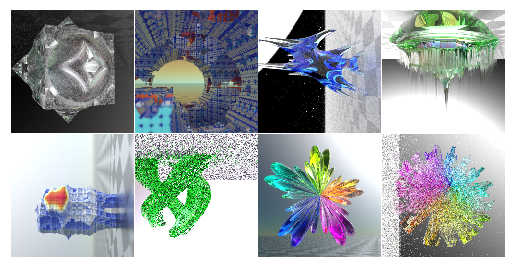

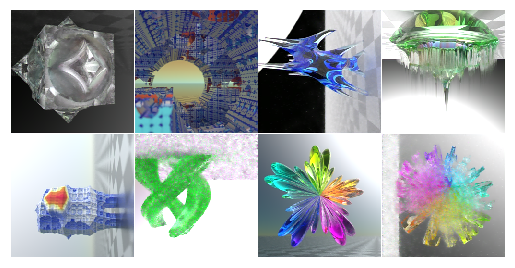

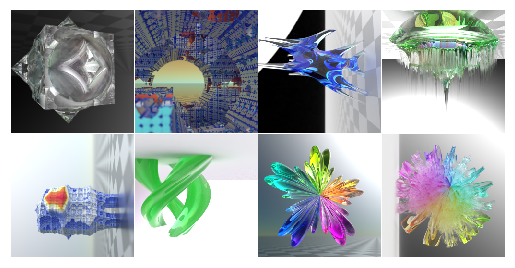

1056 g 1.1797676552087069 d 1.3882678486406803
1088 g 1.0530988238751888 d 1.3880974426865578
1120 g 1.0625199396163225 d 1.388447843492031
1152 g 1.1859474275261164 d 1.3879643827676773
1184 g 1.083158265799284 d 1.3878715187311172
1216 g 1.1046848203986883 d 1.3878340125083923
1248 g 1.0453719086945057 d 1.3876654990017414
1280 g 1.0868487600237131 d 1.3876982480287552
1312 g 0.9378866218030453 d 1.3876664228737354
1344 g 1.114872120320797 d 1.3874463327229023
1376 g 1.0653625298291445 d 1.3877477534115314
1408 g 1.0882383920252323 d 1.387634813785553
1440 g 1.0400538826361299 d 1.387540653347969
1472 g 1.0747270602732897 d 1.3873438872396946
1504 g 1.0115594575181603 d 1.3874333649873734
1536 g 0.9935690313577652 d 1.387310728430748
1568 g 1.008485421538353 d 1.3871590793132782
1600 g 1.0658058244735003 d 1.387137033045292
1632 g 1.0997002571821213 d 1.3869341053068638
1664 g 1.087425496429205 d 1.3869428113102913
1696 g 1.0068291053175926 d 1.3876887150108814
1728 g 1.0913721909746

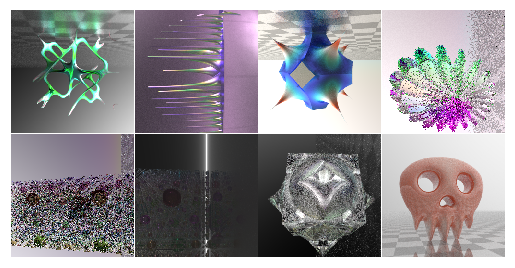

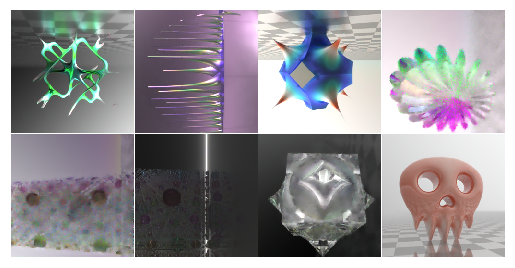

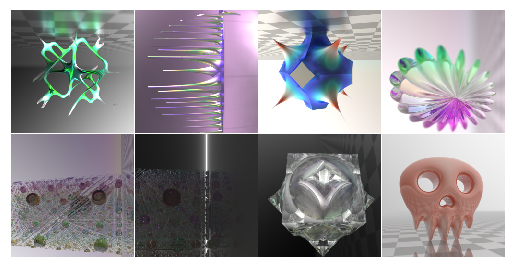

2080 g 1.0032884636893868 d 1.3870322294533253
2112 g 0.9697975851595402 d 1.3868903703987598
2144 g 0.9592812806367874 d 1.386913489550352
2176 g 1.047942604869604 d 1.3868301548063755
2208 g 1.0440571662038565 d 1.386826515197754
2240 g 0.962036058306694 d 1.3867676220834255
2272 g 1.02921343408525 d 1.386722881346941
2304 g 0.9310470707714558 d 1.3867473937571049
2336 g 0.9303421350196004 d 1.3867233395576477
2368 g 1.0350991785526276 d 1.386713556945324
2400 g 0.954539455473423 d 1.3866953440010548
2432 g 0.959872568026185 d 1.3866937048733234
2464 g 0.9365380564704537 d 1.3866459913551807
2496 g 1.0185979586094618 d 1.3866243064403534
2528 g 0.9921712363138795 d 1.3866297267377377
2560 g 0.9782019890844822 d 1.3865585662424564
2592 g 0.9621050525456667 d 1.386525236070156
2624 g 0.9767597019672394 d 1.3864662162959576
2656 g 0.9302630759775639 d 1.386420514434576
2688 g 0.8979774545878172 d 1.3864468857645988
2720 g 0.8570264764130116 d 1.3864637427031994
2752 g 0.9511668253690004

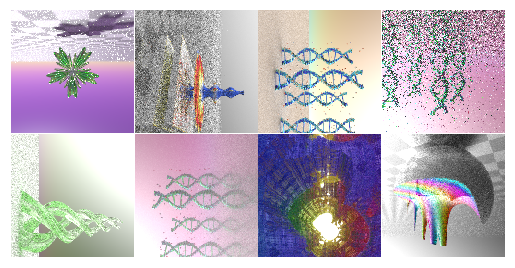

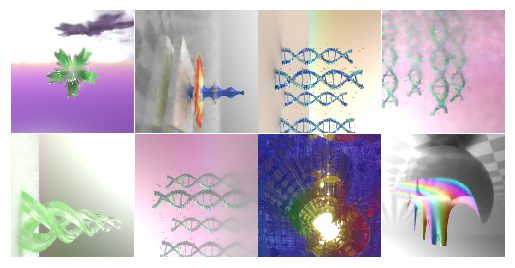

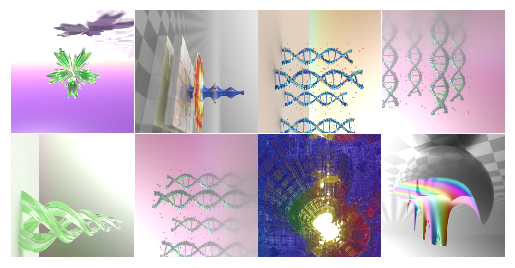

3104 g 0.9087630063295364 d 1.385520201176405
3136 g 0.9499455913901329 d 1.3856703229248524
3168 g 0.9734356962144375 d 1.3828132189810276
3200 g 0.9771923813968897 d 1.380400538444519
3232 g 0.9091879371553659 d 1.3838713020086288
3264 g 0.9314774088561535 d 1.3816334120929241
3296 g 0.9734457470476627 d 1.3721665814518929
3328 g 0.9021059069782495 d 1.385667085647583
3360 g 1.025793470442295 d 1.384396255016327
3392 g 0.8821890614926815 d 1.3799364157021046
3424 g 0.8969615157693624 d 1.375086847692728
3456 g 0.8524997048079967 d 1.3765878453850746
3488 g 0.9072221191599965 d 1.365102645009756
3520 g 0.878033303655684 d 1.3573122471570969
3552 g 0.9594063051044941 d 1.3606544248759747
3584 g 0.8904420863837004 d 1.3361590392887592
3616 g 0.9379614796489477 d 1.3451563231647015
3648 g 0.8410660456866026 d 1.350118275731802
3680 g 0.816753201186657 d 1.344417106360197
3712 g 0.8626940287649632 d 1.3787511922419071
3744 g 0.8081072242930532 d 1.369509432464838
3776 g 0.8968286300078034

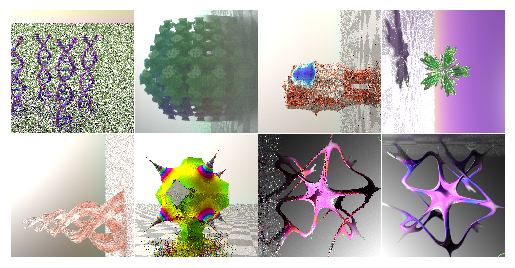

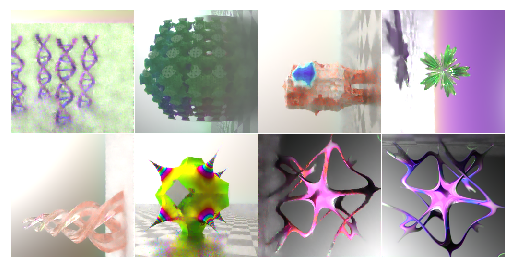

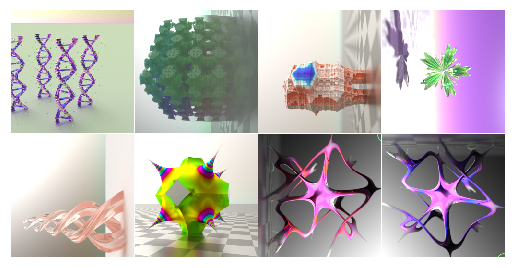

4128 g 0.8864818252623081 d 1.201542779803276
4160 g 0.8437619749456644 d 1.193906843662262
4192 g 0.8602808369323611 d 1.1830909103155136
4224 g 0.8457730151712894 d 1.1770483292639256
4256 g 0.8548479452729225 d 1.1724755391478539
4288 g 0.9014723375439644 d 1.2140840627253056
4320 g 0.8297632709145546 d 1.1936584822833538
4352 g 0.91130087710917 d 1.199170771986246
4384 g 0.9304758459329605 d 1.184833288192749
4416 g 0.7998610036447644 d 1.1591467037796974
4448 g 0.911242138594389 d 1.157362762838602
4480 g 0.9153940826654434 d 1.1593813933432102
4512 g 0.8454848192632198 d 1.1509504541754723
4544 g 0.992220058105886 d 1.1575483605265617
4576 g 0.9066206719726324 d 1.1536782681941986
4608 g 0.8345875972881913 d 1.13597097620368
4640 g 0.8904901146888733 d 1.1329631358385086
4672 g 0.9108262676745653 d 1.1305209062993526
4704 g 0.84721521101892 d 1.1283679381012917
4736 g 0.915057959035039 d 1.161996241658926
4768 g 0.9654428716748953 d 1.122859988361597
4800 g 0.9055860433727503 d 1

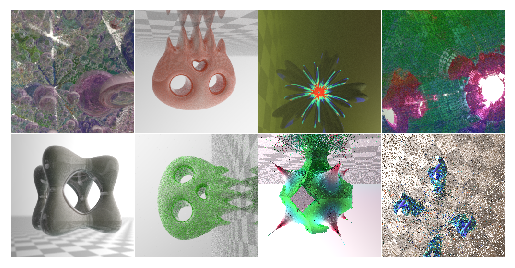

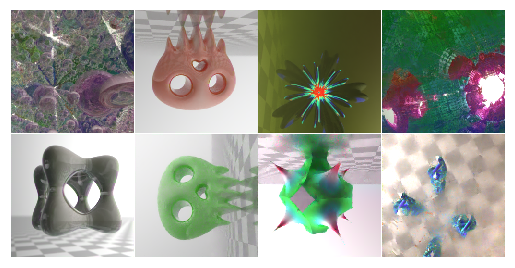

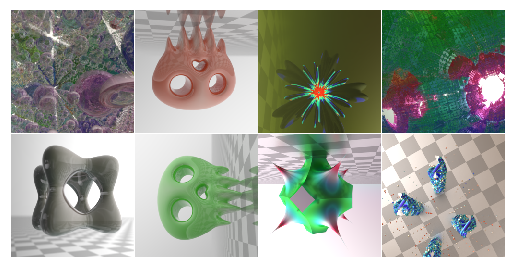

5152 g 0.8358591143041849 d 1.1102317050099373
5184 g 0.8886904306709766 d 1.109282050281763
5216 g 0.8191152233630419 d 1.1090977936983109
5248 g 0.844545328989625 d 1.1175877526402473
5280 g 0.8630227940157056 d 1.1838953606784344
5312 g 0.8341379910707474 d 1.1538803167641163
5344 g 0.8505822261795402 d 1.125642392784357
5376 g 0.8964780494570732 d 1.107821051031351
5408 g 0.8721976624801755 d 1.1048872955143452
5440 g 0.8814228437840939 d 1.118734285235405
5472 g 0.8246592087671161 d 1.1054188311100006
5504 g 0.8552899714559317 d 1.1045936904847622
5536 g 0.8835070068016648 d 1.103473711758852
5568 g 0.8505921782925725 d 1.102451380342245
5600 g 0.9325781604275107 d 1.1027170233428478
5632 g 0.7844759803265333 d 1.1013008058071136
5664 g 0.8139480799436569 d 1.100618865340948
5696 g 0.8801634460687637 d 1.1206098087131977
5728 g 0.8768445998430252 d 1.1129667237401009
5760 g 0.8136111386120319 d 1.0985850095748901
5792 g 0.8485198607668281 d 1.0985001288354397
5824 g 0.866604146547

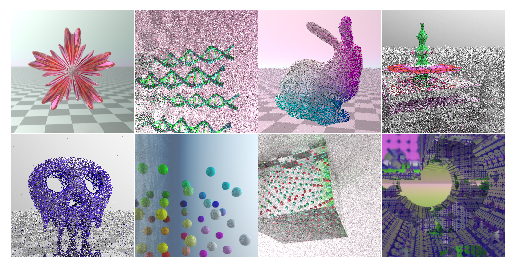

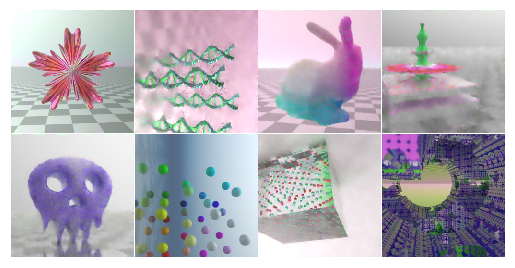

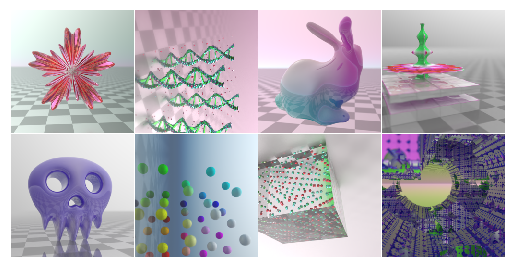

6176 g 0.8115911893546581 d 1.1207298189401627
6208 g 0.831206769682467 d 1.097614012658596
6240 g 0.83916986733675 d 1.1029968075454235
6272 g 0.7853166311979294 d 1.0951581820845604
6304 g 0.7655017906799912 d 1.0959134623408318
6336 g 0.8250908954069018 d 1.0941947847604752
6368 g 0.7831617845222354 d 1.0951232053339481
6400 g 0.8543701888993382 d 1.1082589589059353
6432 g 0.9006264675408602 d 1.0933773778378963
6464 g 0.858103540726006 d 1.0965305417776108
6496 g 0.8385774213820696 d 1.1000176332890987
6528 g 0.8586161825805902 d 1.0943111591041088
6560 g 0.8079226212576032 d 1.092462059110403
6592 g 0.9215458910912275 d 1.0915925800800323
6624 g 0.859340388327837 d 1.1040059067308903
6656 g 0.8242397345602512 d 1.0917307324707508
6688 g 0.8663384541869164 d 1.0913366191089153
6720 g 0.8453714083880186 d 1.091241978108883
6752 g 0.847920686006546 d 1.0912153609097004
6784 g 0.851415092125535 d 1.0904702953994274
6816 g 0.8164543034508824 d 1.0907682925462723
6848 g 0.79887385759502

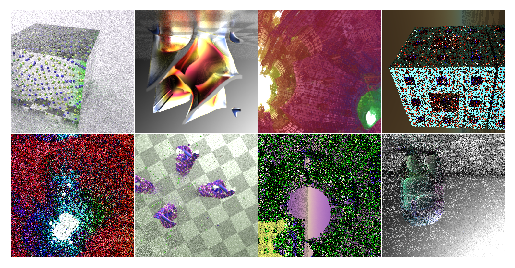

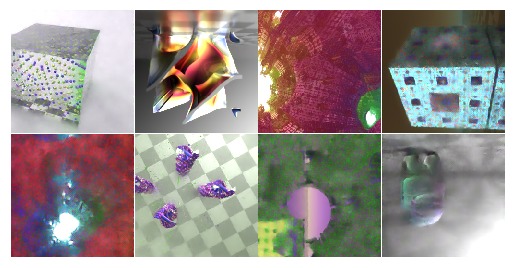

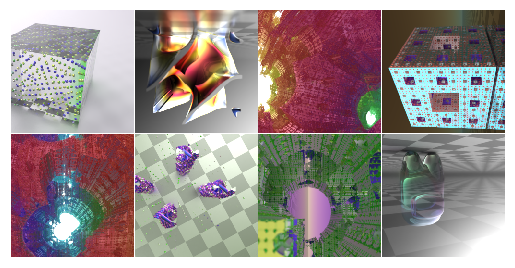

7200 g 0.8027771655470133 d 1.088670514523983
7232 g 0.8344576917588711 d 1.088245429098606
7264 g 0.7862158631905913 d 1.0884462483227253
7296 g 0.8102133711799979 d 1.0880600586533546
7328 g 0.8453570194542408 d 1.0885222665965557
7360 g 0.7359635028988123 d 1.0884120985865593
7392 g 0.832939999178052 d 1.0878480300307274
7424 g 0.8181702988222241 d 1.0876959264278412
7456 g 0.8239580523222685 d 1.0874755792319775
7488 g 0.7472538240253925 d 1.0870971903204918
7520 g 0.777386805973947 d 1.0873221009969711
7552 g 0.8267980515956879 d 1.0869685783982277
7584 g 0.7905716728419065 d 1.0868258737027645
7616 g 0.8140469146892428 d 1.0868129581212997
7648 g 0.723394338041544 d 1.0863423757255077
7680 g 0.8094076598063111 d 1.0865310728549957
7712 g 0.811808168888092 d 1.0861441232264042
7744 g 0.8383565340191126 d 1.0971976220607758
7776 g 0.7202803520485759 d 1.3773640468716621
7808 g 0.9024463761597872 d 1.3858021162450314
7840 g 0.8194578029215336 d 1.38555196672678
7872 g 0.716373700648

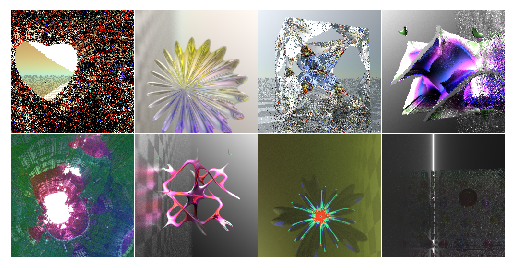

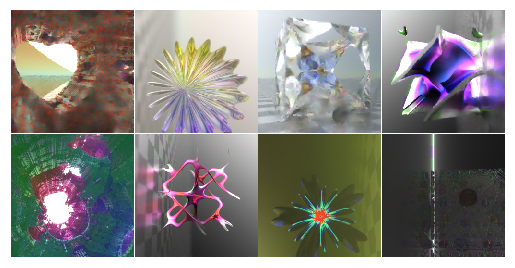

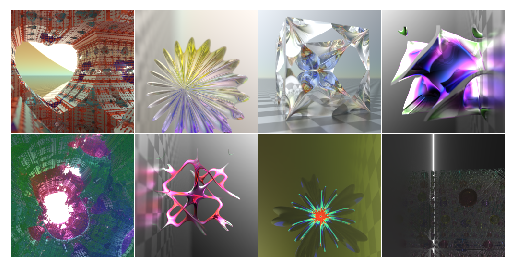

In [7]:
discriminator_params = torch.cat([x.view(-1) for x in discriminator.parameters()])

batch_size = 32
batch_per_epoch = 32
batch_count = 0
terminate = False
mean_loss_g, mean_loss_d = 0.0, 0.0
for epoch in range(4):
    trainloader = torch.utils.data.DataLoader(
        RawDataset(2**17), batch_size=batch_size, shuffle=True)
    for x, y in trainloader:
        x = x.to(device)
        y = y.to(device)
        x = torch.log(1+x)
        y = torch.log(1+y)

        real_labels = torch.ones(batch_size, 1).to(device)
        fake_labels = torch.zeros(batch_size, 1).to(device)

        # Update Discriminator
        optimizer_d.zero_grad()
        real_outputs = discriminator(y)
        d_loss_real = lossfun(None, real_labels, real_outputs, is_discriminator=True)

        fake_images = model(x)
        fake_outputs = discriminator(fake_images.detach())
        d_loss_fake = lossfun(None, fake_labels, fake_outputs, is_discriminator=True)

        d_loss = d_loss_real + d_loss_fake
        d_loss.backward()
        regl2 = 1.0 * torch.mean((discriminator_params)**2)
        regl2.backward()
        optimizer_d.step()

        # Update Generator
        optimizer.zero_grad()
        fake_outputs = discriminator(fake_images)
        g_loss = lossfun(fake_images, y, fake_outputs)
        g_loss.backward()
        optimizer.step()

        batch_count += 1
        mean_loss_g += g_loss.item() / batch_per_epoch
        mean_loss_d += d_loss.item() / batch_per_epoch
        if batch_count % batch_per_epoch == 0:
            print(batch_count, 'g', mean_loss_g, 'd', mean_loss_d)
            scheduler.step(mean_loss_g+mean_loss_d)
            mean_loss_g, mean_loss_d = 0.0, 0.0
            if optimizer.param_groups[0]['lr'] < 0.0005:
                terminate = True
                break
            model_path = "resunet2gan_2.pth"
            torch.save(model, model_path)
        if batch_count % 1024 == 0:
            plot_imgs(torch.exp(x)-1)
            plot_imgs(torch.exp(fake_images.detach())-1)
            plot_imgs(torch.exp(y)-1)
    if terminate:
        break

torch.save(model, model_path)


32 g 0.80671695061028 d 1.100109588354826
64 g 0.7739297514781356 d 1.1044600196182728
96 g 0.8247577315196395 d 1.110421970486641
128 g 0.7551166508346796 d 1.0940012149512768
160 g 0.843106641434133 d 1.0915843956172466
192 g 0.8174472134560347 d 1.0910285152494907
224 g 0.8204969801008701 d 1.0858589485287666
256 g 0.7748576542362571 d 1.0889900960028172
288 g 0.7518618041649461 d 1.0860085934400558
320 g 0.7710496373474598 d 1.0839826725423336
352 g 0.8142992127686739 d 1.0839833728969097
384 g 0.8415972488000989 d 1.0827599465847015
416 g 0.768118629232049 d 1.084212064743042
448 g 0.7964019486680627 d 1.080886896699667
480 g 0.7901160633191466 d 1.0791924111545086
512 g 0.7861700700595975 d 1.0795632973313332
544 g 0.8080639773979783 d 1.0801895894110203
576 g 0.8012353703379631 d 1.0807272344827652
608 g 0.8043028023093939 d 1.0774648785591125
640 g 0.7996167195960879 d 1.1044318415224552
672 g 0.7974484106525779 d 1.0996544398367405
704 g 0.8094353498890996 d 1.0832423456013203

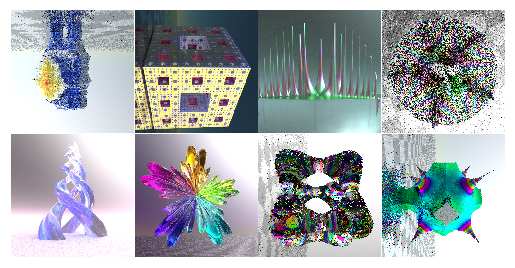

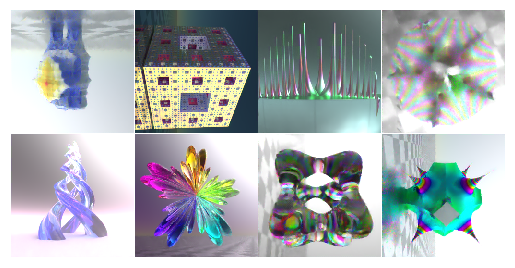

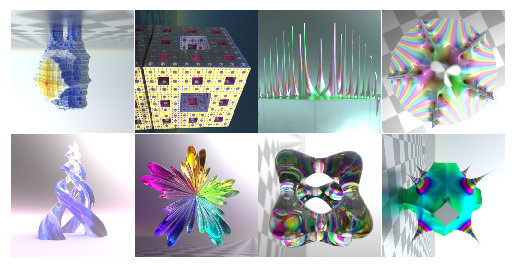

1056 g 0.8048641784116626 d 1.0736781284213066
1088 g 0.8343500010669231 d 1.0723747797310352
1120 g 0.7708852319046855 d 1.072842113673687
1152 g 0.7727731103077531 d 1.0852530524134636
1184 g 0.8185259941965342 d 1.0899835303425789
1216 g 0.8038645181804895 d 1.0758992619812489
1248 g 0.788240454159677 d 1.070539504289627
1280 g 0.790649869479239 d 1.0709659308195114
1312 g 0.82967918086797 d 1.070220436900854
1344 g 0.8333451403304935 d 1.0692258924245834


In [10]:
discriminator_params = torch.cat([x.view(-1) for x in discriminator.parameters()])

batch_size = 32
batch_per_epoch = 32
batch_count = 0
terminate = False
mean_loss_g, mean_loss_d = 0.0, 0.0
for epoch in range(4):
    trainloader = torch.utils.data.DataLoader(
        RawDataset(2**17), batch_size=batch_size, shuffle=True)
    for x, y in trainloader:
        x = x.to(device)
        y = y.to(device)
        x = torch.log(1+x)
        y = torch.log(1+y)

        real_labels = torch.ones(batch_size, 1).to(device)
        fake_labels = torch.zeros(batch_size, 1).to(device)

        # Update Discriminator
        optimizer_d.zero_grad()
        real_outputs = discriminator(y)
        d_loss_real = lossfun(None, real_labels, real_outputs, is_discriminator=True)

        fake_images = model(x)
        fake_outputs = discriminator(fake_images.detach())
        d_loss_fake = lossfun(None, fake_labels, fake_outputs, is_discriminator=True)

        d_loss = d_loss_real + d_loss_fake
        d_loss.backward()
        regl2 = 1.0 * torch.mean((discriminator_params)**2)
        regl2.backward()
        optimizer_d.step()

        # Update Generator
        optimizer.zero_grad()
        fake_outputs = discriminator(fake_images)
        g_loss = lossfun(fake_images, y, fake_outputs)
        g_loss.backward()
        optimizer.step()

        batch_count += 1
        mean_loss_g += g_loss.item() / batch_per_epoch
        mean_loss_d += d_loss.item() / batch_per_epoch
        if batch_count % batch_per_epoch == 0:
            print(batch_count, 'g', mean_loss_g, 'd', mean_loss_d)
            scheduler.step(mean_loss_g+mean_loss_d)
            mean_loss_g, mean_loss_d = 0.0, 0.0
            if optimizer.param_groups[0]['lr'] < 0.0001:
                terminate = True
                break
            model_path = "resunet2gan_2.pth"
            torch.save(model, model_path)
        if batch_count % 1024 == 0:
            plot_imgs(torch.exp(x)-1)
            plot_imgs(torch.exp(fake_images.detach())-1)
            plot_imgs(torch.exp(y)-1)
    if terminate:
        break

torch.save(model, model_path)
